# NMF

In [1]:
import argparse
import warnings
from collections import defaultdict
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.decomposition import PCA, KernelPCA, NMF
from sklearn.manifold import TSNE, MDS, Isomap, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from umap import UMAP
import matplotlib.pyplot as plt
from hassediagram.hasse_diagram import hasse_graphviz

from mcda.dataset import MCDADataset
from mcda.report import calculate_heuristics
from mcda.uta import Criterion, calculate_uta_gms

In [45]:
n_components = [2, 3, 4, 5, 6]

In [46]:
def is_dominating(a_values: List[float], b_values: List[float]) -> bool:
    """
    Check if a is dominating b

    Parameters
    ----------
    a_values (List[float, ...]): List of performances for a
    b_values (List[float, ...]): List of performances for b

    Returns
    -------
    bool: True if a is dominating b, False otherwise

    """
    return all(a >= b for a, b in zip(a_values, b_values)) and any(a > b for a, b in zip(a_values, b_values))

def get_domination_df(n_components: List[int], dataset: MCDADataset) -> pd.DataFrame:
    """
    Get a DataFrame with domination relations for each method and original dataset.

    Parameters
    ----------
    n_components (List[int]): List of number of components for methods
    dataset (MCDADataset): Dataset to check domination relations

    Returns
    -------
    pd.DataFrame: DataFrame with domination relations for each method and original dataset. Indices are tuples that can be passed to `preferences`.
    """

    # Scaling data for methods
    # scaler = StandardScaler()
    # df_scaled = pd.DataFrame(scaler.fit_transform(dataset.data), columns=dataset.data.columns)

    domination = defaultdict(dict)
    for n in n_components:
        # check for each method
        methods = get_methods(n)
        for method_name, method in methods.items():
            df_m = (
                pd.DataFrame(method.fit_transform(dataset.data), index=dataset.data.index, columns=range(n))
                .map(lambda x: f"{x:.4f}")
                .astype(np.float64)
            )
            for alt_1 in df_m.index:
                for alt_2 in df_m.index:
                    if alt_1 == alt_2:
                        continue
                    domination[(method_name, n)][(alt_2, alt_1)] = is_dominating(
                        df_m.loc[alt_1, :].tolist(), df_m.loc[alt_2, :].tolist()
                    )

        # check for original dataset
        for alt_1 in dataset.data.index:
            for alt_2 in dataset.data.index:
                if alt_1 == alt_2:
                    continue
                domination[("original", n)][(alt_2, alt_1)] = is_dominating(
                    dataset.data.loc[alt_1, :].tolist(), dataset.data.loc[alt_2, :].tolist()
                )

    df_domination = pd.DataFrame(domination)
    return df_domination[df_domination.eq(False).all(axis=1)]

In [52]:
def get_methods(n: int) -> dict:
    """
    Get a dictionary of methods for dimensionality reduction.

    Parameters
    ----------
    n (int): Number of components for the methods.

    Returns
    -------
    dict: Dictionary of methods.

    """
    return {
        "NMF": NMF(n_components=n, random_state=42, max_iter=1000)
    }

In [70]:
n_components = [2, 3, 4, 5, 6]
dataset: MCDADataset = MCDADataset.read_csv("./data/building/dataset.csv")
dataset.data = dataset.data + abs(dataset.data.min())

df_domination = get_domination_df(n_components, dataset)
preferences_list = [
    df_domination.index.to_series().sample(1, random_state=i).tolist() for i in range(10)
]
print(preferences_list)
preferences = preferences_list[0]

[[('A8', 'A5')], [('A5', 'A1')], [('A4', 'A5')], [('A8', 'A5')], [('A3', 'A6')], [('A6', 'A5')], [('A6', 'A8')], [('A3', 'A4')], [('A8', 'A7')], [('A3', 'A5')]]


In [71]:
print(dataset.data)

        x1      x2      x3      x4      x5      x6      x7      x8      x9  \
A1  0.0025  0.0015  0.0012  0.0024  0.0013  0.0000  0.0013  0.0007  0.0000   
A2  0.0007  0.0004  0.0003  0.0049  0.0013  0.0140  0.0009  0.0007  0.0332   
A3  0.0018  0.0011  0.0008  0.0000  0.0013  0.0257  0.0007  0.0007  0.0405   
A4  0.0000  0.0000  0.0000  0.0042  0.0013  0.0262  0.0000  0.0007  0.0366   
A5  0.0028  0.0020  0.0017  0.0080  0.0000  0.0075  0.0044  0.0000  0.0000   
A6  0.0011  0.0011  0.0010  0.0101  0.0000  0.0179  0.0041  0.0000  0.0332   
A7  0.0021  0.0016  0.0014  0.0066  0.0000  0.0265  0.0039  0.0001  0.0405   
A8  0.0004  0.0007  0.0007  0.0089  0.0000  0.0268  0.0033  0.0001  0.0366   

       x10  
A1  0.0032  
A2  0.0067  
A3  0.0000  
A4  0.0057  
A5  0.0110  
A6  0.0127  
A7  0.0091  
A8  0.0122  


# Original data

[[0.         0.02126844]
 [0.1079934  0.03018404]
 [0.14755941 0.        ]
 [0.13561429 0.0307627 ]
 [0.00573576 0.07434843]
 [0.11057154 0.07296031]
 [0.14459859 0.05411581]
 [0.1333332  0.07148701]]


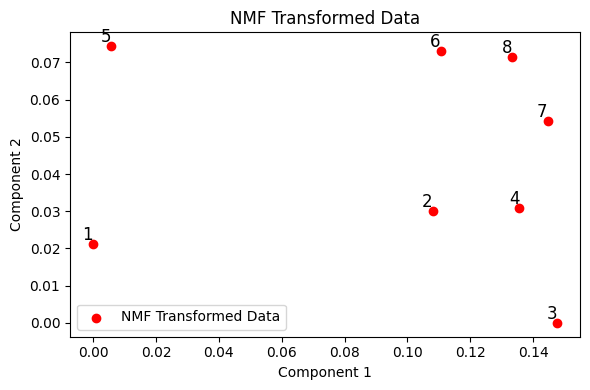

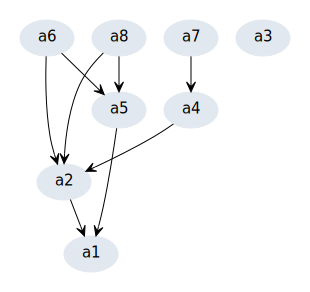

In [72]:
N_components = 2
nmf = NMF(n_components=N_components, random_state=42, max_iter=1000)
transformed_data = nmf.fit_transform(dataset.data)

print(transformed_data)

# Plot original data
plt.figure(figsize=(6, 4))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], color='red', label="NMF Transformed Data")
for i, (x, y) in enumerate(transformed_data, start=1):
    plt.text(x, y, str(i), fontsize=12, ha='right', va='bottom')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("NMF Transformed Data")
plt.legend()

plt.tight_layout()
plt.show()

df_m = pd.DataFrame(transformed_data, index=dataset.data.index, columns=range(N_components))\
                    .map(lambda x: f"{x:.4f}")\
                    .astype(np.float64)
criteria = [Criterion(name, points=2) for name in df_m.columns]
df_utagms = calculate_uta_gms(df_m, preferences, criteria)
hasse_graphviz(df_utagms.values)

/usr/local/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


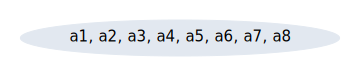

In [56]:
n_components = 3
df_m = pd.DataFrame(NMF(n_components=n_components, random_state=42).fit_transform(dataset.data), index=dataset.data.index, columns=range(n_components))\
                    .map(lambda x: f"{x:.4f}")\
                    .astype(np.float64)
criteria = [Criterion(name, points=2) for name in df_m.columns]
df_utagms = calculate_uta_gms(df_m, preferences, criteria)
hasse_graphviz(df_utagms.values)

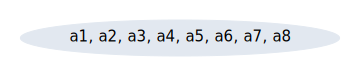

In [38]:
n_components = 4
df_m = pd.DataFrame(NMF(n_components=n_components, random_state=42).fit_transform(dataset.data), index=dataset.data.index, columns=range(n_components))\
                    .map(lambda x: f"{x:.4f}")\
                    .astype(np.float64)
criteria = [Criterion(name, points=2) for name in df_m.columns]
df_utagms = calculate_uta_gms(df_m, preferences, criteria)
hasse_graphviz(df_utagms.values)

/usr/local/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


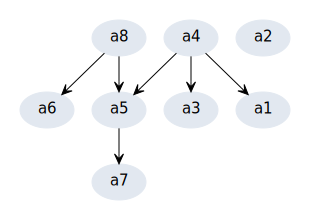

In [39]:
n_components = 5
df_m = pd.DataFrame(NMF(n_components=n_components, random_state=42).fit_transform(dataset.data), index=dataset.data.index, columns=range(n_components))\
                    .map(lambda x: f"{x:.4f}")\
                    .astype(np.float64)
criteria = [Criterion(name, points=2) for name in df_m.columns]
df_utagms = calculate_uta_gms(df_m, preferences, criteria)
hasse_graphviz(df_utagms.values)

/usr/local/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


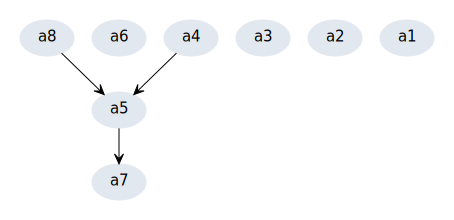

In [40]:
n_components = 6
df_m = pd.DataFrame(NMF(n_components=n_components, random_state=42).fit_transform(dataset.data), index=dataset.data.index, columns=range(n_components))\
                    .map(lambda x: f"{x:.4f}")\
                    .astype(np.float64)
criteria = [Criterion(name, points=2) for name in df_m.columns]
df_utagms = calculate_uta_gms(df_m, preferences, criteria)
hasse_graphviz(df_utagms.values)

/usr/local/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


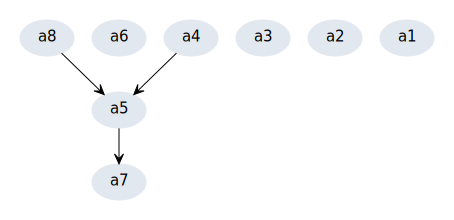

In [41]:
n_components = 7
df_m = pd.DataFrame(NMF(n_components=n_components, random_state=42).fit_transform(dataset.data), index=dataset.data.index, columns=range(n_components))\
                    .map(lambda x: f"{x:.4f}")\
                    .astype(np.float64)
criteria = [Criterion(name, points=2) for name in df_m.columns]
df_utagms = calculate_uta_gms(df_m, preferences, criteria)
hasse_graphviz(df_utagms.values)